In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd

df_final=pd.read_csv('..\\Assests\\data\\final_insurance_dataV2.csv')
# Split features and target
X = df_final.drop(columns=["claim_status"])
y = df_final["claim_status"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [2]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [3]:
import pickle
# Save scaler locally
scaler_path = "..\\Assests\\model\\standard_scalerV2.pkl"
with open(scaler_path, "wb") as f:
    pickle.dump(scaler, f)

In [4]:
import mlflow
import os
import mlflow.sklearn

mlflow.set_experiment('insure_claim_Scaler_logV2')

with mlflow.start_run(run_name='scaler_log_runV2'):
    mlflow.log_artifact(scaler_path,artifact_path='Scaler')
    mlflow.log_param('Scaler','Standard Scaler')
    mlflow.log_metric('Train Shape', X_train.shape[0])
    
print(f"Scaler saved as: {os.path.abspath(scaler_path)}")

2025/06/15 11:06:59 INFO mlflow.tracking.fluent: Experiment with name 'insure_claim_Scaler_logV2' does not exist. Creating a new experiment.


Scaler saved as: c:\Users\ssutk2\OneDrive - Cardiff University\Documents\ClaimInsure\Assests\model\standard_scalerV2.pkl


In [7]:
from sklearn.linear_model import LogisticRegression
baselineModelV2=LogisticRegression(
    penalty='l2',
    C=1.0,
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

In [8]:
from sklearn.metrics import roc_auc_score, f1_score, classification_report
with mlflow.start_run(run_name='LogisticRegressionBaselineV2'):
    baselineModelV2.fit(X_train_scaled,y_train)
    yPred=baselineModelV2.predict(X_test_scaled)
    y_proba=baselineModelV2.predict_proba(X_test_scaled)[:,1]
    
    auc_roc=roc_auc_score(y_test,y_proba)
    f1= f1_score(y_test,yPred)

    mlflow.log_metric('auc',auc_roc)
    mlflow.log_metric('f1',f1)

    mlflow.log_param("penalty", "l2")
    mlflow.log_param("C", 1.0)
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("max_iter", 1000)

    mlflow.sklearn.log_model(baselineModelV2, 'logistic regression')
    
    print("✔️ Model logged to MLflow")
    print("AUC Score:", auc_roc)
    print("F1 Score :", f1)

2025/06/15 11:13:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/15 11:14:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔️ Model logged to MLflow
AUC Score: 0.5925959288392681
F1 Score : 0.14427600627286985


In [9]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, f1_score
import mlflow
import mlflow.sklearn

# Define model
xgb_modelV2 = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # balance positive class
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Start MLflow run
with mlflow.start_run(run_name="xgboost_baselineV2"):
    xgb_modelV2.fit(X_train_scaled, y_train)
    y_pred = xgb_modelV2.predict(X_test_scaled)
    y_proba = xgb_modelV2.predict_proba(X_test_scaled)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)

    # Log model and metrics
    mlflow.sklearn.log_model(xgb_modelV2, "xgboost_model")
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("F1", f1)

    print("✔️ XGBoost model logged to MLflow")
    print(f"AUC Score: {auc:.4f}")
    print(f"F1 Score : {f1:.4f}")


C:\Users\ssutk2\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:14:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2025/06/15 11:14:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/15 11:14:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔️ XGBoost model logged to MLflow
AUC Score: 0.5735
F1 Score : 0.1372


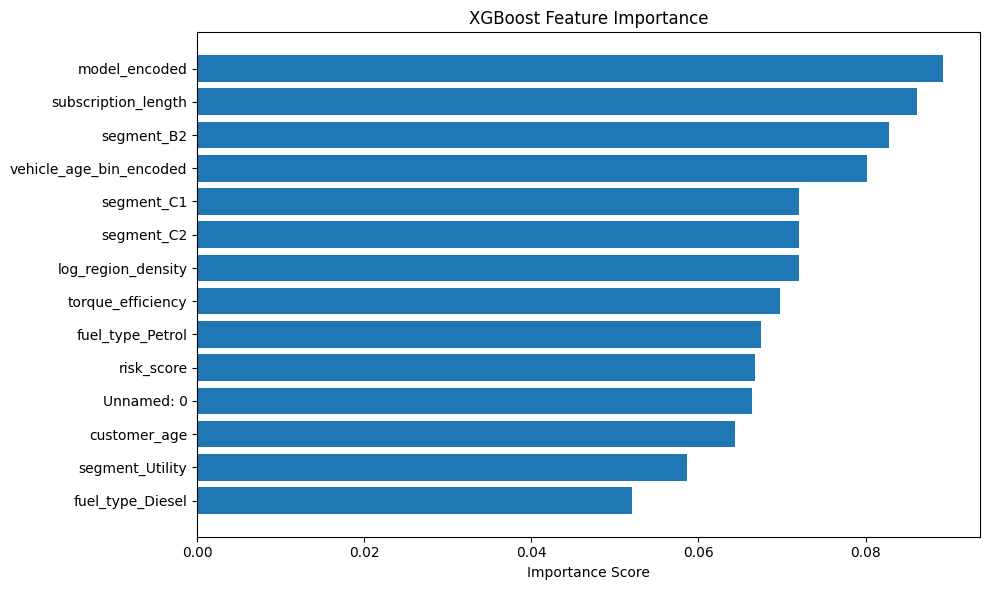

In [11]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
feature_importance = xgb_modelV2.feature_importances_
features = X.columns
sorted_idx = feature_importance.argsort()

plt.barh(features[sorted_idx], feature_importance[sorted_idx])
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [12]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import mlflow
import mlflow.sklearn
from sklearn.metrics import roc_auc_score, f1_score, make_scorer

# Define parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3]
}

# Initialize base model
xgb_modelV2 = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Define scoring
scorer = make_scorer(f1_score)

# Set up random search
random_search = RandomizedSearchCV(
    estimator=xgb_modelV2,
    param_distributions=param_grid,
    scoring=scorer,
    cv=3,
    verbose=1,
    n_iter=30,
    random_state=42,
    n_jobs=-1
)

# MLflow logging
with mlflow.start_run(run_name="xgboost_randomsearchV2"):
    random_search.fit(X_train_scaled, y_train)
    
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)

    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("F1", f1)

    mlflow.log_params(random_search.best_params_)
    mlflow.sklearn.log_model(best_model, "xgboost_tuned_modelV2")

    print("✔️ Tuned XGBoost model logged to MLflow")
    print(f"Best Params: {random_search.best_params_}")
    print(f"AUC Score  : {auc:.4f}")
    print(f"F1 Score   : {f1:.4f}")


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\ssutk2\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:16:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2025/06/15 11:16:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/15 11:17:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔️ Tuned XGBoost model logged to MLflow
Best Params: {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}
AUC Score  : 0.6031
F1 Score   : 0.1469


In [13]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, make_scorer
import mlflow
import mlflow.sklearn

# Define parameter grid for CatBoost
param_grid = {
    'iterations': [300, 500, 700],
    'depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'random_strength': [1, 5, 10]
}

# Create base model
cat_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    auto_class_weights='Balanced',
    verbose=0,
    random_seed=42
)

# Define F1 scorer for optimization
scorer = make_scorer(f1_score)

# RandomizedSearchCV setup
random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_grid,
    scoring=scorer,
    n_iter=30,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Start MLflow run
with mlflow.start_run(run_name="catboost_randomsearchV2"):
    random_search.fit(X_train_scaled, y_train)

    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)

    # Log to MLflow
    mlflow.log_params(random_search.best_params_)
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("F1", f1)
    mlflow.sklearn.log_model(best_model, "catboost_tuned_modelV2")

    print("✔️ Tuned CatBoost model logged to MLflow")
    print(f"Best Params: {random_search.best_params_}")
    print(f"AUC Score  : {auc:.4f}")
    print(f"F1 Score   : {f1:.4f}")


Fitting 3 folds for each of 30 candidates, totalling 90 fits


2025/06/15 11:23:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/15 11:23:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔️ Tuned CatBoost model logged to MLflow
Best Params: {'subsample': 0.8, 'random_strength': 10, 'learning_rate': 0.01, 'l2_leaf_reg': 7, 'iterations': 300, 'depth': 7}
AUC Score  : 0.6065
F1 Score   : 0.1518


 1. Check for signal in data

Ask: Is there enough predictive power in the features?
Actions:

    Plot feature importances from all your tree models (you’ve done it for XGBoost).

    Use SHAP values (especially for CatBoost or XGBoost) to see if:

        any features consistently drive prediction,

        or if features contribute very little (which means limited signal).

C:\Users\ssutk2\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


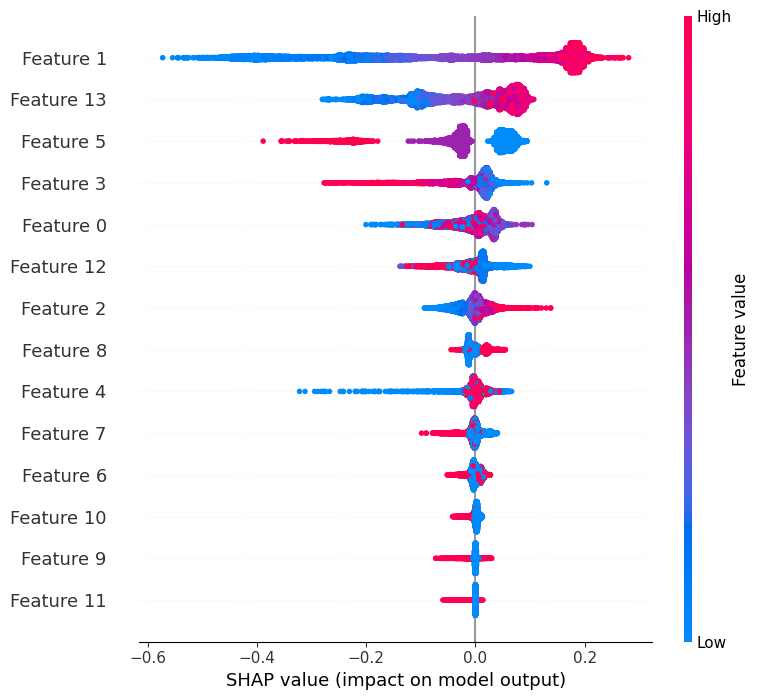

In [14]:
import shap
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled)

📊 2. Check if data is learnable at all

Ask: Is even a high-capacity model able to learn something useful?
Actions:

    Overfit a simple tree (max_depth=10, no regularization) or a CatBoost model with many iterations on a small subset of data (e.g., 2000 samples).

        If it can’t even overfit, that’s a red flag—data has poor separability.



In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Subset small portion of training data
X_small = X_train_scaled[:2000]
y_small = y_train[:2000]

# Train an unconstrained tree
dt = DecisionTreeClassifier(max_depth=20, min_samples_split=2)
dt.fit(X_small, y_small)

# Evaluate on same data (intentionally overfitting)
y_pred = dt.predict(X_small)
print(classification_report(y_small, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1873
           1       1.00      0.98      0.99       127

    accuracy                           1.00      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000



In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, make_scorer
import mlflow
import mlflow.sklearn

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Create base model
rf_model = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Define F1 scorer
scorer = make_scorer(f1_score)

# Setup randomized search
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    scoring=scorer,
    n_iter=30,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# MLflow logging
with mlflow.start_run(run_name="random_forest_randomsearch"):
    random_search.fit(X_train_scaled, y_train)

    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)

    # Log to MLflow
    mlflow.log_params(random_search.best_params_)
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("F1", f1)
    mlflow.sklearn.log_model(best_model, "random_forest_tuned_model")

    print("✔️ Tuned Random Forest model logged to MLflow")
    print(f"Best Params: {random_search.best_params_}")
    print(f"AUC Score  : {auc:.4f}")
    print(f"F1 Score   : {f1:.4f}")


Fitting 3 folds for each of 30 candidates, totalling 90 fits


2025/06/15 10:38:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/15 10:39:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔️ Tuned Random Forest model logged to MLflow
Best Params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 5, 'bootstrap': True}
AUC Score  : 0.6056
F1 Score   : 0.1517


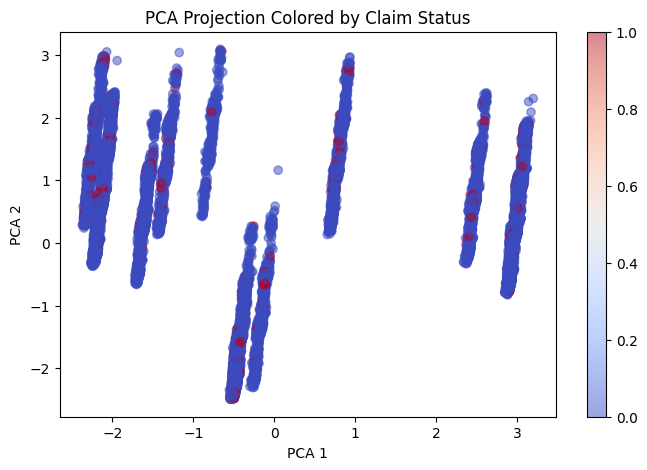

In [48]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='coolwarm', alpha=0.5)
plt.title("PCA Projection Colored by Claim Status")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar()
plt.show()


In [50]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, f1_score
import xgboost as xgb
import mlflow
import mlflow.sklearn

# Apply SMOTE on training data only
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Re-initialize XGBoost (no need for scale_pos_weight when using SMOTE)
final_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    colsample_bytree=1.0,
    gamma=0,
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=1,
    n_estimators=500,
    subsample=0.6
)

# Train and log with MLflow
with mlflow.start_run(run_name="xgboost_final_model_smote"):
    final_xgb.fit(X_train_balanced, y_train_balanced)

    y_pred = final_xgb.predict(X_test_scaled)
    y_proba = final_xgb.predict_proba(X_test_scaled)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)

    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("F1", f1)
    mlflow.sklearn.log_model(final_xgb, "final_xgboost_model_smote")

    print("✔️ Final XGBoost + SMOTE model trained & logged")
    print(f"AUC Score  : {auc:.4f}")
    print(f"F1 Score   : {f1:.4f}")


C:\Users\ssutk2\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [10:48:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2025/06/15 10:48:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/15 10:48:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔️ Final XGBoost + SMOTE model trained & logged
AUC Score  : 0.5905
F1 Score   : 0.1354


❌ SMOTE introduces synthetic noise	Your dataset already has low signal, and adding "fake" minority examples blurs boundaries more.
⚠️ Minority class is not well-clustered	Your PCA earlier showed claims (class 1) are scattered → SMOTE can't interpolate meaningfully.
🧪 You already had scale_pos_weight	It was handling imbalance quite effectively without data distortion.
⛔ Test set is real, not synthetic	So model trained on SMOTE data may overfit to artificial patterns not seen in test set.

In [5]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, f1_score
import mlflow
import mlflow.sklearn

# Final model with best hyperparameters
final_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    colsample_bytree=1.0,
    gamma=0,
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=1,
    n_estimators=500,
    subsample=0.6
)

# Train
final_xgb.fit(X_train_scaled, y_train)

# Predict
y_pred = final_xgb.predict(X_test_scaled)
y_proba = final_xgb.predict_proba(X_test_scaled)[:, 1]

# Evaluate
auc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)

print(f"AUC Score : {auc:.4f}")
print(f"F1 Score  : {f1:.4f}")


C:\Users\ssutk2\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:07:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC Score : 0.6057
F1 Score  : 0.1487


In [53]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score

# Get predicted probabilities
y_proba = final_xgb.predict_proba(X_test_scaled)[:, 1]

# Evaluate multiple thresholds
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []
precisions = []
recalls = []

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh))
    precisions.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_thresh))

# Find the best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"✅ Best Threshold: {best_threshold:.2f}")
print(f"F1 Score: {f1_scores[best_idx]:.4f}")
print(f"Precision: {precisions[best_idx]:.4f}")
print(f"Recall: {recalls[best_idx]:.4f}")


✅ Best Threshold: 0.52
F1 Score: 0.1548
Precision: 0.0899
Recall: 0.5557


In [54]:
# Define custom prediction function
def predict_with_threshold(model, X, threshold=0.52):
    """Returns predicted labels using custom threshold."""
    y_proba = model.predict_proba(X)[:, 1]
    return (y_proba >= threshold).astype(int)


In [55]:
# Get threshold-optimized predictions
y_pred_thresholded = predict_with_threshold(final_xgb, X_test_scaled, threshold=0.52)

# Evaluate new predictions
f1 = f1_score(y_test, y_pred_thresholded)
precision = precision_score(y_test, y_pred_thresholded)
recall = recall_score(y_test, y_pred_thresholded)

print(f"🔎 Threshold: 0.52")
print(f"F1 Score    : {f1:.4f}")
print(f"Precision   : {precision:.4f}")
print(f"Recall      : {recall:.4f}")


🔎 Threshold: 0.52
F1 Score    : 0.1548
Precision   : 0.0899
Recall      : 0.5557


In [56]:
X_train_scaled

array([[-1.14366471,  1.58396694, -1.05243347, ..., -0.26288324,
        -0.58790365, -0.15243374],
       [-1.26483977, -1.28703442, -0.33971454, ..., -0.26288324,
        -0.58790365, -0.15243374],
       [-0.00461915, -1.28703442,  1.50259667, ..., -0.26288324,
         1.70095898, -0.15243374],
       ...,
       [ 0.45584608, -0.71283415, -0.33971454, ..., -0.26288324,
        -0.58790365, -0.15243374],
       [-0.58625944, -1.28703442, -1.05243347, ..., -0.26288324,
        -0.58790365, -0.15243374],
       [ 1.1101914 , -0.28218395,  1.50259667, ..., -0.26288324,
         1.70095898, -0.15243374]])

In [15]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, f1_score
import pandas as pd

results = []

for feature in X_train.columns:
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    
    model.fit(X_train[[feature]], y_train)
    y_proba = model.predict_proba(X_test[[feature]])[:, 1]
    y_pred = model.predict(X_test[[feature]])
    
    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    
    results.append({'feature': feature, 'AUC': auc, 'F1': f1})

# Create DataFrame
feature_scores = pd.DataFrame(results).sort_values(by='AUC', ascending=False)


C:\Users\ssutk2\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:24:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ssutk2\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:24:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ssutk2\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:24:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ssutk2\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:24:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\lear

In [16]:
feature_scores


,feature,AUC,F1
1,subscription_length,0.590228,0.144482
13,risk_score,0.562674,0.135187
3,log_region_density,0.522137,0.125292
12,torque_efficiency,0.515006,0.115778
4,model_encoded,0.512853,0.107781
7,fuel_type_Petrol,0.511822,0.116813
8,segment_B2,0.510695,0.114927
5,vehicle_age_bin_encoded,0.509732,0.114823
0,Unnamed: 0,0.506241,0.117347
2,customer_age,0.505595,0.113200
